In [1]:
import argparse
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt

from tqdm import trange
from utils.config import Config
from model import ICNet, ICNet_BN

Instructions for updating:
non-resource variables are not supported in the long term


# Setup configurations

In [2]:
model_config = {'train': ICNet, 'trainval': ICNet, 'train_bn': ICNet_BN, 'trainval_bn': ICNet_BN, 'others': ICNet_BN}

# Choose dataset here, but remember to use `script/downlaod_weight.py` first
dataset = 'cityscapes'
filter_scale = 1
    
class InferenceConfig(Config):
    def __init__(self, dataset, is_training, filter_scale):
        Config.__init__(self, dataset, is_training, filter_scale)
    
    # You can choose different model here, see "model_config" dictionary. If you choose "others", 
    # it means that you use self-trained model, you need to change "filter_scale" to 2.
    model_type = 'trainval'

    # Set pre-trained weights here (You can download weight from Google Drive) 
    model_weight = './model/cityscapes/icnet_cityscapes_train_30k_bnnomerge.npy'
    
    # Define default input size here
    INFER_SIZE = (1024, 2048, 3)
                  
cfg = InferenceConfig(dataset, is_training=False, filter_scale=filter_scale)
cfg.display()

Setup configurations...

Configurations:
ADE20K_DATA_DIR                ./data/ADEChallengeData2016/
ADE20K_eval_list               ./data/list/ade20k_val_list.txt
ADE20K_train_list              ./data/list/ade20k_train_list.txt
BATCH_SIZE                     16
CITYSCAPES_DATA_DIR            ./data/cityscapes_dataset/cityscape/
CITYSCAPES_eval_list           ./data/list/cityscapes_val_list.txt
CITYSCAPES_train_list          ./data/list/cityscapes_train_list.txt
IMG_MEAN                       [103.939 116.779 123.68 ]
INFER_SIZE                     (1024, 2048, 3)
LAMBDA1                        0.16
LAMBDA2                        0.4
LAMBDA3                        1.0
LEARNING_RATE                  0.0001
MOMENTUM                       0.9
N_WORKERS                      12
POWER                          0.9
RANDOM_SEED                    1234
SAVE_NUM_IMAGES                4
SAVE_PRED_EVERY                500
SNAPSHOT_DIR                   /home/antonioc/Scrivania/ML/autodeeplabVSother

# Create graph, session, and restore weights

In [3]:
# Create graph here 
model = model_config[cfg.model_type]
net = model(cfg=cfg, mode='inference')

# Create session & restore weight!
net.create_session()
net.restore(cfg.model_weight)

Restore from ./model/cityscapes/icnet_cityscapes_train_30k_bnnomerge.npy


# Run segmentation on single image

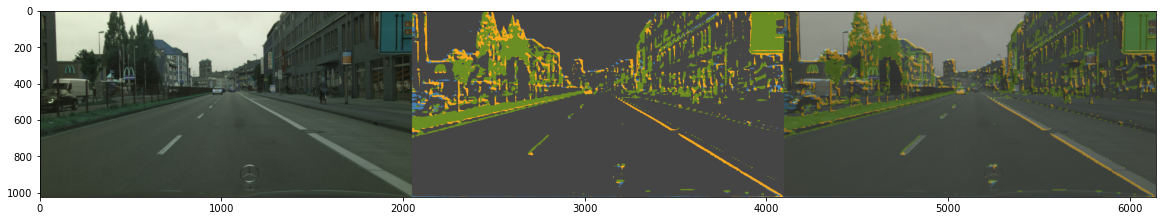

In [7]:
im1 = cv2.imread('./data/input/cityscapes1.png')

if im1.shape != cfg.INFER_SIZE:
    im1 = cv2.resize(im1, (cfg.INFER_SIZE[1], cfg.INFER_SIZE[0]))

results1 = net.predict(im1)
overlap_results1 = 0.5 * im1 + 0.5 * results1[0]
vis_im1 = np.concatenate([im1/255.0, results1[0]/255.0, overlap_results1/255.0], axis=1)

plt.figure(figsize=(20, 15))
plt.imshow(vis_im1)

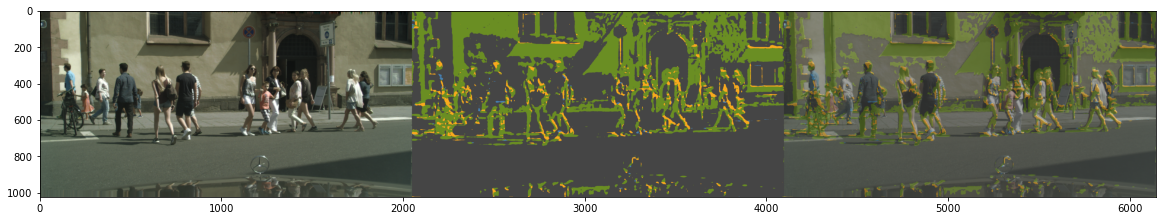

In [8]:
im2 = cv2.imread('./data/input/cityscapes2.png')
results2 = net.predict(im2)

im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
overlap_results2 = 0.5 * im2 + 0.5 * results2[0]

vis_im2 = np.concatenate([im2/255.0, results2[0]/255.0, overlap_results2/255.0], axis=1)

plt.figure(figsize=(20, 15))
plt.imshow(vis_im2)

# Test inference speed

In [9]:
elapsed_times = []

for i in range(50):
    start_t = time.time()
    
    _ = net.predict(im1)
    
    duration = time.time() - start_t
    
    if i > 0:
        elapsed_times.append(duration)

print('Average time: {:.4f}, about {:.6f} fps'.format(np.mean(elapsed_times), 1/np.mean(elapsed_times)))

Average time: 0.0660, about 15.151344 fps
